# Product Data Analysis. Related Products
_________

Alexey Zhukov <br>
20/09/2022

zhuuukds@gmail.com | https://www.linkedin.com/in/zhuuukds | https://zhuuukds.github.io | +972533432370
__________

## Task Formulation

Some categories in the product range are related. For example, phone accessories are useless without the phones themselves. Therefore, for promotions, mailings, and recommendations, it is important to know the existence of this kind dependencies between categories and in categories with themselves (if users access the category repeatedly). What are the dependencies, and between which categories, if we consider only purchases? How does the user behave when browsing products? How are purchases fundamentally different from views, and why?

Find insights, with explanations. Graphics are welcome.

## Data Description

We are given a dataset from a online shop's related database. This dataset contains data about users behavior and product catalog:

- product views
- category views
- product purchases
- lists of products and categories

The sample was formed only from sessions of users who looked at product pages at least 3 times, or bought any product. The dataset was created on the basis of historical records for the last 6 months in such a way that all existing dependencies and distributions are preserved, but there is no information in the dataset about the sequence of visiting by a particular person.

The data is anonymized. Session, order and product IDs have been replaced with hashes. A monotonic transformation is applied to the cost of goods in such a way that the ratio between the prices of goods is preserved. Category IDs and their names, as well as product brands, are not modified.

The dataset provides all the necessary categories that are in the catalog, as well as information about purchased and part of non-purchased goods.

## Data Importing and Preprocessing

In [1]:
import pandas as pd
import numpy as np

In [2]:
products = pd.read_csv('data/products.csv', sep = ';')
categories = pd.read_csv('data/categories.csv', sep = ',', index_col=[0])
purchases = pd.read_csv('data/purchases.csv', sep = ';')
product_categories = pd.read_csv('data/product-categories.csv', sep = ';')
item_views = pd.read_csv('data/item-views.csv', sep = ';', index_col=[0])
category_views = pd.read_csv('data/category-views.csv', sep = ';')

In [3]:
# a table of orders with added product categories info
order_cat = pd.merge(purchases, product_categories, on='product_id')
order_cat = pd.merge(order_cat, categories, on='category_id')

# group by users
user_cat = order_cat.groupby(['externalsessionid', 'category_id'], as_index=False) \
                    .agg(orders_count = ('ordernumber', 'count'))

# table of categories and amount of orders by them
# 1. group by orders, users and categories
# 2. group by users and categories, sale_count - amount of category orders for each user
# 3. group by categories
purch_by_cat = order_cat.groupby(['category_id', 'name', 'ordernumber', 'externalsessionid'], as_index=False) \
                        .agg({'timestamp':'count'}) \
                        .groupby(['category_id', 'name', 'externalsessionid'], as_index=False) \
                        .agg(sale_count=('timestamp', 'count')) \
                        .groupby(['category_id', 'name'], as_index=False) \
                        .agg(sale_count=('sale_count', 'sum'), user_count_sale = ('sale_count', 'count')) 

# We will do a similar operation for views.
# In terms of table construction, viewing is like ordering. But the order has an ID and the view does not.
# So let's artificially introduce it. View ID = User ID + View day.
# That is, we consider all views of one user within one day to be a single entity


In [4]:
view_cat = pd.merge(category_views, categories, on='category_id')
view_cat['ordernumber'] = view_cat['externalsessionid'].map(str) + ' ' + view_cat["eventdate"]

In [5]:
view_user_cat = view_cat.groupby(['externalsessionid','category_id'], as_index=False) \
                        .agg(orders_count=('timestamp', 'count'))

view_by_cat = view_cat.groupby(['category_id', 'name', 'externalsessionid', 'ordernumber'], as_index=False).count() \
                        .groupby(['category_id', 'name', 'externalsessionid'], as_index=False) \
                        .agg(view_count=('timestamp', 'count')) \
                        .groupby(['category_id', 'name'], as_index=False) \
                        .agg(view_count=('view_count', 'sum'), user_count_view = ('view_count', 'count'))

In [6]:
# General final table, which provides information on the number of orders and views for each category
general_df = view_by_cat.merge(purch_by_cat.iloc[:,[0,2,3]], on='category_id', how='outer')

## General Statistics

First of all, let's take a look at the overall picture of views and sales by category.

In this section, under the number of sales (we will also use the term “number of purchases” as a synonym) of a category, we will understand the following: how many times a product of this category was listed in __distinct__ orders. At the same time, we will not take into account the number of goods, since goods of different categories are bought in different quantities (it is unlikely that someone will buy two fridges at once, but 4 tires at once is quite likely).

Let's give an example for clarity:


| Order | Item | Category | Quantity |
| --- | --- | --- |---|
| 4242 | Regular cat food | Cat food | 2
| 4242 | Diet cat food | Cat food | 5
| 4242 | Bicycle Stork | Bicycles | 1
| 1812 | Regular cat food | Cat food | 3
| 1812 | Bicycle Desna | Bicycles | 1

The number of purchases in the `Cat Food` category will be `2`, as will the number of purchases in the `Bicycle category`. It is important to remember this point so that in the future not to confuse the number of purchases with the total number of purchases of the category (it would be: `2` for `bicycles` and `10` for `cat food`). This is done because some categories are more often bought together with themselves (for example, self-tapping screws of different lengths), some less often (refrigerators). This, of course, also needs to be taken into account, and such interaction will be discussed below, but in order to assess the overall popularity of categories, it would be more correct to get rid of such “duality”.

Since we will also analyze category views, the number of category views will be determined similarly to the number of purchases. But the view does not have a number - there is only the date and duration of the view. Therefore, we will take views made by one user within one day as a viewing unit. Since if a user visited the website several times a day, it would be incorrect to consider this as different views: most likely, he came in search of the same product.

#### Comparing views and purchases in absolute terms
Let's take a look at the charts that show the top categories by sales and views:

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

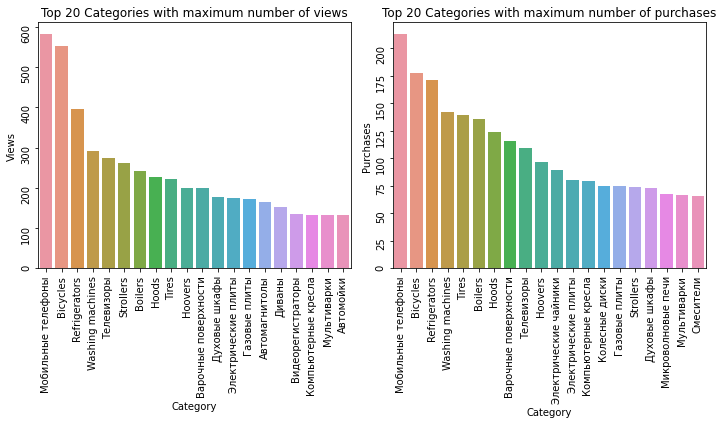

In [8]:
cat_views_plot = general_df.sort_values(['view_count', 'category_id'], ascending=False).head(20)
cat_orders_plot = general_df.sort_values(['sale_count', 'category_id'], ascending=False).head(20)

f, axs = plt.subplots(1, 2, figsize=(10, 6))

a = sns.barplot(x='name', y='view_count', data=cat_views_plot, ax=axs[0])
b = sns.barplot(x='name', y='sale_count', data=cat_orders_plot, ax=axs[1])

axs[0].tick_params(rotation=90)
axs[1].tick_params(rotation=90)

axs[0].set_title('Top 20 Categories with maximum number of views')
axs[1].set_title('Top 20 Categories with maximum number of purchases')

axs[0].set(xlabel="Category", ylabel="Views")
axs[1].set(xlabel="Category", ylabel="Purchases")

f.tight_layout()
plt.show()

Looking at these figures, we can see that the top 20 for sales and views are very similar in many ways.

Let's show the relationship between the number of purchases and views in the context of categories more clearly:

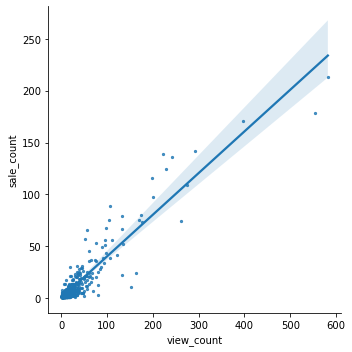

In [9]:
sns.lmplot(x='view_count', y='sale_count', data=general_df, scatter_kws={"s": 5})

It can be seen that there is a fairly clear relationship between views and purchases.
This is confirmed by the correlation coefficient, which for these values equals `0.93`. Which indicates a significant relationship between the number of purchases and views.

In [10]:
general_df.view_count.corr(general_df.sale_count)

0.9310143729205755

#### Comparing views and purchases by unique users
The above data may be distorted. The amount of data is not very large, and therefore the number of purchases of a certain category could be strongly influenced by just a couple of people. For example, a customer who changes mobile phones once a week could greatly inflate the Mobile Phones category.

To check whether there was such a distortion, we will build a graph on which we compare the number of unique users who bought with the number of purchases. We'll make a similar comparison for views as well:

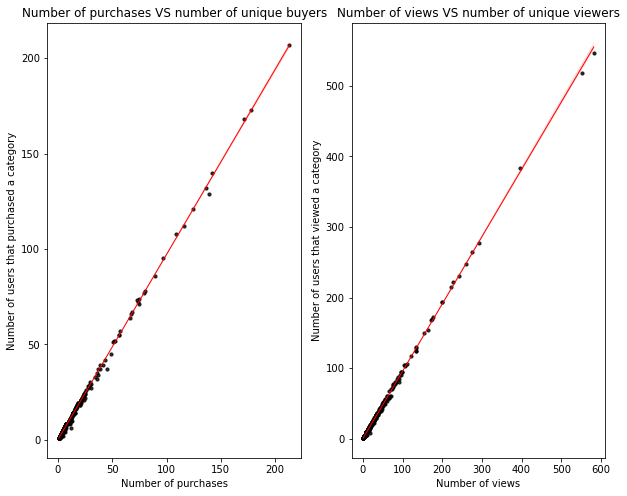

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(10, 8))

sns.regplot(x='sale_count', y='user_count_sale', data=general_df, ax=axes[0],scatter_kws={"color": "black", 's':10}, line_kws={"color": "red", 'linewidth':1})
axes[0].set_title('Number of purchases VS number of unique buyers')
axes[0].set(xlabel="Number of purchases", ylabel="Number of users that purchased a category")

sns.regplot(x='view_count', y='user_count_view', data=general_df, ax=axes[1], scatter_kws={'color':'black', 's':10}, line_kws={'color':'red', 'linewidth':1})
axes[1].set_title('Number of views VS number of unique viewers')
axes[1].set(xlabel="Number of views", ylabel="Number of users that viewed a category")

plt.show()

These graphs show that the indicators are almost the same, so there is no point in correcting the calculations made in the previous section. It also means that quite a few users make repeat purchases or views. But more will be said about this later on.

So, we can say that user behavior during browsing and during purchases practically does not differ from each other. But there are significantly more category views than actual purchases, which is to be expected.

## Category relationships

We start with the assumption that users buy some products that related to other products, or return to the same product category. This may happen for the following reasons:

1. Buying accessories. For example *(phone - phone case)*
2. Purchase of related equivalent goods. *(a fume hood and a microwave)*
3. Periodic “restocking” or seasonal purchases *(printer cartridges or  summer and winter tires)*

Information about related products can be useful for promotional mailings, for recommendations to the user, for reminders to “restock”, etc.

### Related products

#### Related products purchases

First, let's find out which product categories are related to each other. The algorithm for determining related categories for a particular category is quite simple:

1) Select orders that contain goods from the analyzed category

2) Remove from these orders the goods belonging to the analyzed category. Moreover, if the order contains several products of this category, then we will delete only one: since it is important to understand the relationship of the category with itself. If there's a strong relation within a category, then the user can be actively offered products from the same category. For example, when a user looks for or buys a protective glass for a cell phone, we offer him a case (if both of these products belong to the same category)

3) In the resulting table, we summarize the number of purchases for each category *(again, without considering the quantity, but note that now the number of purchases is affected by the repetition of a category in the same order)*.

4) Divide the number of purchases in each category by the total amount of purchases. Thus, we get the share of each category in related purchases for the analyzed category. The higher this indicator, the stronger the relationship between categories. For convenience, we can name this indicator as `connection strength` between the categories.

5) Sort the table in descending order of connection strength. We will get a list of all categories associated with the analyzed category. Depending on the specific task, we can use either the entire resulting table, or only the first few lines. Given the relatively small amount of initial data, it may make sense to limit ourselves to only one first line from the list of related categories.

In [12]:
# let's create a function 'find_categories'
def find_categories(orderdf, cat_id, cat_name=''):
    # select the orders in which the analyzed category occurred
    ord_n_for_cat = orderdf[orderdf.category_id == cat_id].ordernumber.unique()
    an_cat_ord_count = len(ord_n_for_cat) #amount of orders with this category 
    cat_for_cat = orderdf[orderdf.ordernumber.isin(ord_n_for_cat)].category_id
    # how many times the analyzed category was purchased
    cat_by_itself = cat_for_cat[cat_for_cat == cat_id]
    cat_sales = len(cat_by_itself)
    # calculate category frequencies
    df_cat_for_cat = pd.DataFrame(cat_for_cat)
    df_cat_for_cat = df_cat_for_cat.groupby(df_cat_for_cat.category_id, as_index=False).agg(Freq=('category_id', 'count'))
    
    # correct the analyzed category itself by the number of orders in this category. 
    # all that on top is the "connection" of the category with itself.
    df_cat_for_cat.loc[df_cat_for_cat.category_id == cat_id, 'Freq'] = df_cat_for_cat[df_cat_for_cat.category_id == cat_id]['Freq'] - an_cat_ord_count
    df_cat_for_cat = df_cat_for_cat[df_cat_for_cat.Freq > 0]

    df_cat_for_cat = pd.merge(df_cat_for_cat, categories.iloc[:,[0,2]], on = "category_id")
    
    # calculate the percentage of sales of "companions". 
    # category frequency per total number of companion sales
    df_cat_for_cat['acc_percent'] = df_cat_for_cat.Freq / df_cat_for_cat.Freq.sum()

    # just add the initial fields to the table
    df_cat_for_cat.assign(an_cat_id = np.repeat(cat_id, len(df_cat_for_cat)),
                      an_cat_name = np.repeat(cat_name, len(df_cat_for_cat)))

    # number of sales of the analyzed category
    df_cat_for_cat['an_cat_sales'] = np.repeat(cat_sales, len(df_cat_for_cat))


    # calculate the ratio of the number of sales of the companion category to the number of sales of the analyzed category
    res = df_cat_for_cat.sort_values('acc_percent', ascending=False) 
    res = res.rename(columns={'Freq': 'Amount of purchases', 
                         'category_id': 'Related category id',
                         'acc_percent': 'Connection strength',
                         'name': 'Related category name'})
    res = res.loc[:,['Related category id', 'Related category name', 'Amount of purchases', 'Connection strength']]
    
    return res   

Now let's take a look on examples for some real couples of categories.

__Шпатели (category_d = 486):__

In [13]:
find_categories(order_cat, 486)

,Related category id,Related category name,Amount of purchases,Connection strength
0,486,Шпатели,6,0.857143
1,514,Очки защитные,1,0.142857


__Кронштейны для ТВ (category_id = 7):__

In [14]:
find_categories(order_cat, 7).head(15)

,Related category id,Related category name,Amount of purchases,Connection strength
0,3,Телевизоры,22,0.338462
4,17,Hoovers,4,0.061538
8,26,Refrigerators,3,0.046154
2,7,TV brackets,3,0.046154
16,97,Мыши,2,0.030769
14,82,Ноутбуки,2,0.030769
25,332,Компьютерные кресла,2,0.030769
9,32,Электрические плиты,2,0.030769
7,25,Микроволновые печи,2,0.030769
6,20,Утюги,2,0.030769


Information in the tables seem to be correct. In the case of 'Шпатели', the category is strongly related to itself.

In this case, when user buys 'Шпатели', we can suggest a product in the 'Шпатели' category rather than nothing or a completely unrelated product.

*(If you look at the original data set, you can see that the same user actually bought all the 'Шпатели'. Judging on the basis of the actions of a single user about the presence of a connection may not be entirely correct. However, we have no other data at all.)*

Now we can build a table for all categories.
Let's display the TOP 5% of the categories that are most related to each other.
Since the size of the original dataset is not very large, the table contains many categories with a number of related sales equal to one.
For clarity (and also because such related sales are less likely to be "garbage"), we will display in the table only those related categories that have a number of sales greater than 2

In [15]:
rel_cat_purchases = pd.DataFrame(columns=['Analizing category', *(find_categories(view_cat, 486).columns.values.tolist())])

for i in range(1, len(categories)):
    most_related_category = find_categories(order_cat, i)
    if len(most_related_category):
        most_related_category['Analizing category'] = categories.loc[categories.category_id==i, ['name']].values[0][0]
        most_related_category = most_related_category[most_related_category['Amount of purchases'] > 2]
        rel_cat_purchases = pd.concat([rel_cat_purchases, most_related_category], ignore_index=True)

In [16]:
rel_cat_purchases = rel_cat_purchases.iloc[:,[0, 2, 3, 4]]
rel_cat_purchases.sort_values(['Connection strength', 'Amount of purchases'], ascending=False).head(20)

,Analizing category,Related category name,Amount of purchases,Connection strength
242,Фрезы для фрезерных станков,Фрезы для фрезерных станков,9,1.0
279,Очки защитные,Шпатели,7,1.0
196,Настенные часы,Настенные часы,3,1.0
278,Шпатели,Шпатели,6,0.857143
241,Аксессуары для круглошлифовальных машин,Шлифовальные машины,5,0.714286
277,Маски сварочные,Сварочные аппараты,8,0.666667
188,Аксессуары для стиральных машин,Washing machines,4,0.666667
180,Колесные диски,Tires,16,0.64
276,Сифоны,Смесители,6,0.6
167,Сварочные аппараты,Маски сварочные,8,0.571429


All couples look pretty logical. Separately, it is worth highlighting the category "Tires - Wheels". Possessing a fairly powerful connection, this category also has a large number of sales, that is, the connection is as reliable as possible.

#### Related Product Views
Now we can take a look at a similar table, but for product views.

Since there are more views than purchases, we will display not the TOP-5%, but the TOP-1%. And the number of views of both the analyzed and the related category will be limited from below at the level of 12.

In [17]:
rel_cat_views = pd.DataFrame(columns=['Analizing category', *(find_categories(view_cat, 486).columns.values.tolist())])

for i in range(1, len(categories)):
    most_related_category = find_categories(view_cat, i)
    if len(most_related_category):
        most_related_category['Analizing category'] = categories.loc[categories.category_id==i, ['name']].values[0][0]
        most_related_category = most_related_category[most_related_category['Amount of purchases'] > 12]
        rel_cat_views = pd.concat([rel_cat_views, most_related_category], ignore_index=True)

In [18]:
rel_cat_views.sort_values(['Connection strength', 'Amount of purchases'], ascending=False).head(20)

,Analizing category,Related category id,Related category name,Amount of purchases,Connection strength
93,Машинки для стрижки,88,Машинки для стрижки,79,0.711712
171,Велосипеды для малышей,337,Велосипеды для малышей,60,0.652174
101,Пылесборники,107,Пылесборники,13,0.65
72,Швейные машины,57,Швейные машины,82,0.630769
200,Bicycles,848,Bicycles,395,0.617188
212,Насосы,1066,Насосы,72,0.610169
156,Детские автокресла,323,Детские автокресла,68,0.596491
120,Стабилизаторы напряжения,185,Стабилизаторы напряжения,16,0.571429
80,Boilers,62,Boilers,175,0.557325
197,Сушилки для продуктов,601,Сушилки для продуктов,39,0.557143


Most connections here are the "A-A" type, that is, between the same category of goods. This is quite logical: when people want a certain product, they look at several products from the category they need.

In order to confirm this more clearly, let's define the maximum related category for each category for purchased products, and then for viewed products. Our hypothesis is that for viewed products, there will be significantly more cases where the most related category for a category is itself (that is, there will be more cases of "A-A" association than in purchased products). 

In [19]:
purchase_a_a = rel_cat_purchases.assign(A_A = np.where(rel_cat_purchases['Analizing category'] == rel_cat_purchases['Related category name'], 'yes', 'no'), 
                                              type = 'Purchase')[['type', 'A_A']]
view_a_a = rel_cat_views.assign(A_A = np.where(rel_cat_views['Analizing category'] == rel_cat_views['Related category name'], 'yes', 'no'), 
                                              type = 'View')[['type', 'A_A']]
equals = pd.concat([purchase_a_a, view_a_a], ignore_index=True)
equals.columns = ['Action Type', 'A-A connection']

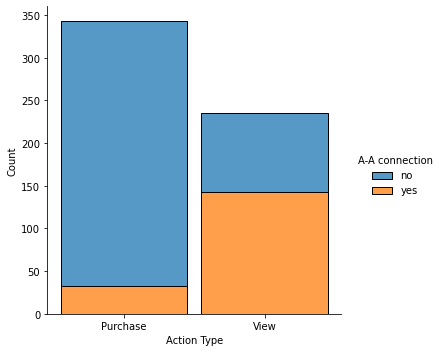

In [20]:
sns.displot(x='Action Type', data=equals, hue='A-A connection', multiple="stack", shrink=.9)
plt.savefig('data/action.png')

Indeed, there are more A-A connections in 'views' than in 'purchases'. 

Therefore, distinct (non 'A-A') related categories are best defined by 'purchase' data rather than 'views' data.

### Accessories
 
As mentioned above, some products are complements to others. We will conditionally call such goods "accessories".
For example, if a user buys a TV-stand, then he certainly has a TV. And offering accessories in addition to the purchased product can be profitable for the business.
So, finding Accessories is very important task. 

We know that there're lots of A-A connections, especially in 'views' data. In such cases, related product is not an accessory. Therefore, we will use the following approach:
- take only 'purchases' data
- define the accessory as a product:
    - which is in the most related category (connection strength > 0.1),
    - but not in the same category
    - and in category with an average price 2 times less than target product category price

In [21]:
rel_cat_purchases = rel_cat_purchases[rel_cat_purchases['Connection strength'] >= 0.1]

In [22]:
# calculate average price for each category
cat_price = product_categories.merge(products, on='product_id').merge(categories, on='category_id')
cat_price = cat_price.groupby(['category_id','name_y'], as_index=False).agg(mean_price=('price', 'mean')).rename(columns={'category_id':'Related category id'})

In [23]:
# find accessoires
accessoires = rel_cat_purchases.copy()
#accessoires['analazing_cat_price'] = pd.Series

In [24]:
# adding analized category mean price 
acc = pd.merge(accessoires, 
               cat_price[['name_y', 'mean_price']], 
               left_on='Analizing category', 
               right_on='name_y', how='left') \
                .rename(columns={'mean_price': 'Analized category mean price'})

In [25]:
# adding related category mean price 
acc = pd.merge(acc, 
               cat_price[['name_y', 'mean_price']], 
               left_on='Related category name', 
               right_on='name_y', how='left') \
                .rename(columns={'mean_price': 'Related category mean price'})

In [26]:
# find the related categories with mean price 2 times less than analyzed category mean price
acc = acc[2*acc['Related category mean price'] <= acc['Analized category mean price']]

In [27]:
acc.iloc[:,[0, 5, 1, 7, 3]]

,Analizing category,Analized category mean price,Related category name,Related category mean price,Connection strength
0,Телевизоры,3153.159533,TV brackets,476.449405,0.267442
5,Refrigerators,3768.229350,Электрические плиты,1460.469108,0.126437
22,Духовые шкафы,2952.926186,Hoods,1315.617902,0.229167
25,Встраиваемые посудомоечные машины,3355.354839,Hoods,1315.617902,0.16129
28,Мобильные телефоны,1252.740933,Чехлы для сотовых телефонов,337.500000,0.113636
30,Ноутбуки,3888.567347,Мыши,375.462916,0.180328
31,Компьютеры,3672.271795,Мыши,375.462916,0.125
34,Компьютеры,3672.271795,Компьютерная акустика,640.215247,0.1
46,Жесткие диски,1484.388571,Оперативная память,722.270115,0.142857
51,Перфораторы,1085.967568,Ленты для шлифовальных машин,305.391304,0.142857


All pairs in the table look logically related!

#### Conclusions
Users browse products more than they make purchases. At the same time, when browsing, they view products of the same category more often than when buying. This can be explained by the fact that when choosing a product, the user also views its analogues. When shopping, this behavior is not observed, most of the goods purchased in one order belong to different categories. 

It was possible to create algorithms for determining the following dependencies:
 - Related products
 - Accessories to main products (a subset of related products)

The practical importance of the results obtained may be as follows:

 - When user is browsing, offer him/her to view products from the same category. If there are “accessories” for the product category, then also offer them.
 - After purchasing the product (with recommendations / advertising on the site or in mailing lists):
     - if the product is not an “accessory”, then we can offer the user products from related categories;
     - if the product is an "accessory" for a main product, then we should offer, first of all, products from the related categories of the main product. That is, other 'accessories' for the main product.


